# 1. Train Custom Cellpose Model 
- Export images for training 
- Train model 
- Plot train/test loss 
- Export example images of out-of-sample data 

gg-napari-env

In [15]:
from napari_czifile2 import napari_get_reader
from cellpose import models, core, models, train
from cellpose.io import logger_setup
import cellpose.io as cio 
import torch 
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os 
from skimage.measure import regionprops
from plotting import * 

In [16]:
use_GPU = core.use_gpu()
torch.cuda.empty_cache()
print('>>> GPU activated? %d'%use_GPU)
logger_setup()

2025-07-09 11:31:54,532 [INFO] ** TORCH CUDA version installed and working. **
>>> GPU activated? 1
2025-07-09 11:31:54,587 [INFO] WRITING LOG OUTPUT TO /home/tracking/.cellpose/run.log
2025-07-09 11:31:54,587 [INFO] 
cellpose version: 	3.1.0 
platform:       	linux 
python version: 	3.12.8 
torch version:  	2.5.1+cu124


(<Logger cellpose.io (INFO)>, PosixPath('/home/tracking/.cellpose/run.log'))

In [17]:
import matplotlib.font_manager as fm
fm.fontManager.__init__()

2025-07-09 11:31:55,344 [INFO] Failed to extract font properties from /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: Could not set the fontsize (invalid pixel size; error code 0x17)


## Export Images for Training 

In [4]:
raw_data_dirs = os.listdir('../../../RNA-FISH-raw-data/')
raw_data_dirs

['20250508 P14 T 9E89-b1-546 9E99-B2-647 DAPI',
 '20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI',
 '20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI',
 '20250325 6 P14 9E198-B3-488 9E197-B1-546 9E196-B2-647 DAPI',
 '20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI',
 '20250508 P14 T 9E99-b2-594 LOC105286072-B5-647 DAPI',
 '20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI',
 '20250325 5 P14 G1-b1-546 lnc7-B2-647 DAPI',
 '20250523 C P14 T U54-647 Lnc4-546 DAPI',
 '20250523 A P14 T 9E213-546 9E214-488 Intergenic-647 DAPI',
 '20250325 4 P14 U34-B3-488 lnc4-B1-546 U21-B5-647 DAPI',
 '20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI',
 '20250701 A P14 9E118-EXONS-B1-546 9E118-INTRONS-B2-647 9E129-B3-488 DAPI',
 'temp_not_for_paper',
 '20250328 4 P14 9E129-b3-488 LOC104-b1-546 9E116-b2-647 DAPI',
 '20250701 F P14 U34-b3-546 Orco-b4-647 DAPI',
 '20250523 B P14 T 9E88-546 Lnc-647 DAPI']

In [5]:
input = 'Chymotrypsin'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
input_dir = os.path.join('../../../RNA-FISH-raw-data/', input)
assert os.path.exists(input_dir), 'Input directory does not exist'
czi_files = [f for f in os.listdir(input_dir) if f.endswith('.czi')]
print(f"Found {len(czi_files)} czi files in {input_dir}")
print(czi_files)

Using 20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI as input directory
Found 5 czi files in ../../../RNA-FISH-raw-data/20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI
['20250307 B1 Sample 5 Stack.czi', '20250307 B1 Sample 4 Stack.czi', '20250307 B1 Sample 1 Stack.czi', '20250307 B1 Sample 3 Stack.czi', '20250307 B1 Sample 2 Stack.czi']


In [8]:
file = czi_files[1]
file_path = os.path.join(input_dir, file)
reader = napari_get_reader(file_path)
if reader is not None:
    layer_data = reader(file_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {file_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

Loaded ../../../RNA-FISH-raw-data/20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI/20250307 B1 Sample 4 Stack.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 0.5, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'DAPI-T2', 'AF647-T2']}
Image shape: (1, 202, 3, 2048, 2048)


In [9]:
# Export to a folder for training 
output_dir = f"../cellpose-model-training/new-images/{file.replace(".czi", "")} slices"
os.makedirs(output_dir, exist_ok=True)

# Sizes of zooms 
n_slices = 10
np.random.seed(9)
dapi_index = metadata['name'].index([name for name in metadata['name'] if 'DAPI' in name][0])
slices = np.random.choice(image_data.shape[1], n_slices)
for i, s in enumerate(slices):
    slice_data = image_data[0,s,dapi_index,:,:]
    io.imsave(f"{output_dir}/{file.replace(".czi", f"_{i}.tif")}", slice_data)
    print(f"Saved {output_dir}/{file.replace('.czi', f'_{i}.tif')}")

Saved ../cellpose-model-training/new-images/20250307 B1 Sample 4 Stack slices/20250307 B1 Sample 4 Stack_0.tif
Saved ../cellpose-model-training/new-images/20250307 B1 Sample 4 Stack slices/20250307 B1 Sample 4 Stack_1.tif
Saved ../cellpose-model-training/new-images/20250307 B1 Sample 4 Stack slices/20250307 B1 Sample 4 Stack_2.tif
Saved ../cellpose-model-training/new-images/20250307 B1 Sample 4 Stack slices/20250307 B1 Sample 4 Stack_3.tif
Saved ../cellpose-model-training/new-images/20250307 B1 Sample 4 Stack slices/20250307 B1 Sample 4 Stack_4.tif
Saved ../cellpose-model-training/new-images/20250307 B1 Sample 4 Stack slices/20250307 B1 Sample 4 Stack_5.tif
Saved ../cellpose-model-training/new-images/20250307 B1 Sample 4 Stack slices/20250307 B1 Sample 4 Stack_6.tif
Saved ../cellpose-model-training/new-images/20250307 B1 Sample 4 Stack slices/20250307 B1 Sample 4 Stack_7.tif
Saved ../cellpose-model-training/new-images/20250307 B1 Sample 4 Stack slices/20250307 B1 Sample 4 Stack_8.tif
S

## Train Model 

In [18]:
train_dir = '../cellpose-model-training/model_B_only_OSNs/train'
test_dir = '../cellpose-model-training/model_B_only_OSNs/test'

output = cio.load_train_test_data(train_dir, test_dir, mask_filter="_seg.npy")
train_images, train_labels, image_names, test_images, test_labels, image_names_test = output

2025-07-09 11:32:00,444 [INFO] not all flows are present, running flow generation for all images
2025-07-09 11:32:01,610 [INFO] 17 / 17 images in ../cellpose-model-training/model_B_only_OSNs/train folder have labels
2025-07-09 11:32:01,790 [INFO] not all flows are present, running flow generation for all images
2025-07-09 11:32:02,448 [INFO] 8 / 8 images in ../cellpose-model-training/model_B_only_OSNs/test folder have labels


LR = 0.1, n_epochs=300, weight_decay=0.0001

In [19]:
model = models.CellposeModel(model_type="nuclei", gpu=True) 
model_name = "model_B_only_OSNs"
model_path = '../cellpose-model-training/model_B_only_OSNs'
model_path, train_losses, test_losses = train.train_seg(model.net,
                            train_data=train_images, train_labels=train_labels,
                            channels=[0, 0], # DAPI 
                            save_path=model_path,
                            test_data=test_images, test_labels=test_labels,
                            weight_decay=1e-4, SGD=True, learning_rate=0.005, rescale=True, 
                            n_epochs=500, model_name=model_name)

2025-07-09 11:32:36,324 [INFO] >> nuclei << model set to be used
2025-07-09 11:32:36,342 [INFO] ** TORCH CUDA version installed and working. **
2025-07-09 11:32:36,344 [INFO] >>>> using GPU (CUDA)
2025-07-09 11:32:36,377 [INFO] >>>> loading model /home/tracking/.cellpose/models/nucleitorch_0
2025-07-09 11:32:36,404 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-07-09 11:32:36,406 [INFO] computing flows for labels


/home/tracking/miniconda3/envs/gg-napari-env/lib/python3.12/site-packages/cellpose/resnet_torch.py:271: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load

2025-07-09 11:32:39,224 [INFO] computing flows for labels



100%|██████████| 8/8 [00:01<00:00,  5.38it/s]

2025-07-09 11:32:40,744 [INFO] >>> computing diameters



100%|██████████| 8/8 [00:00<00:00, 87.78it/s]

2025-07-09 11:32:41,092 [WARNING] 1 train images with number of masks less than min_train_masks (5), removing from train set
2025-07-09 11:32:41,093 [INFO] >>> using channels [0, 0]
2025-07-09 11:32:41,094 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': True, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}


2025-07-09 11:32:43,524 [INFO] >>> n_epochs=500, n_train=16, n_test=8
2025-07-09 11:32:43,525 [INFO] >>> SGD, learning_rate=0.00500, weight_decay=0.00010, momentum=0.900
2025-07-09 11:32:43,527 [INFO] >>> saving model to ../cellpose-model-training/model_B_only_OSNs/models/model_B_only_OSNs
2025-07-09 11:32:44,506 [INFO] 0, train_loss=0.4838, test_loss=0.5811, LR=0.000000, time 0.98s
2025-07-09 11:32:48,227 [INFO] 5, train_loss=0.6095, test_loss=0.4943, LR=0.002778, time 4.70s
2025-07-09 11:32:51,934 [INFO] 10, train_loss=0.4836, test_loss=0.3837, LR=0.005000, time 8.41s
2025-07-09 11:32:59,410 [INFO] 20, train_loss=0.3647, test_loss=0.3065, LR=0.005000, time 15.88s
2025-07-09 11:33:06,928 [INFO] 30, train_loss=0.3322, test_loss=0.2992, LR=0.005000, time 23.40s
2025-07-09 11:33:13,813 [INFO] 40, train_loss=0.3037, test_loss=0.2844, LR=0.005000, time 30.29s
2025-07-09 11:33:20,995 [INFO] 50, train_loss=0.2497, test_loss=0.2783, LR=0.005000, time 37.47s
2025-07-09 11:33:28,069 [INFO] 60, 

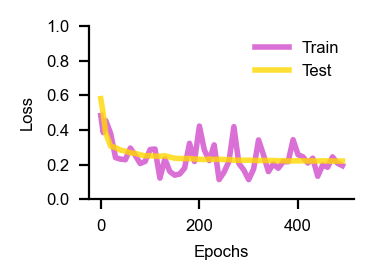

In [20]:
# Plot losses
white_plotting()
f, ax = plt.subplots(1, 1, figsize=(2, 1.5), dpi=200)
ax.plot(np.where(test_losses > 0)[0], train_losses[test_losses > 0], label='Train', color='orchid', lw=2)
ax.plot(np.where(test_losses > 0)[0], test_losses[test_losses > 0], label='Test', color='gold', lw=2, alpha=0.8)
ax.set_xlabel('Epochs', fontsize=6)
ax.set_ylabel('Loss', fontsize=6)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(fontsize=6, frameon=False)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/{model_name}_losses.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

In [21]:
# Save train and test losses
model_path = '../cellpose-model-training/model_B_only_OSNs/models'
os.makedirs(model_path, exist_ok=True)
model_name = "model_B_only_OSNs"
np.save(f"{model_path}/train_losses_{model_name}.npy", train_losses)
np.save(f"{model_path}/test_losses_{model_name}.npy", test_losses)

In [14]:
# Load train and test losses
model_path = '../cellpose-model-training/model_B_only_OSNs/models'
model_name = "model_B_only_OSNs"
train_losses = np.load(f"{model_path}/train_losses_{model_name}.npy")
test_losses = np.load(f"{model_path}/test_losses_{model_name}.npy")

## Test Model on Held-Out Data 

In [19]:
# Load trained model 
model_path = '../cellpose-model-training/model_B_only_OSNs/models/model_B_only_OSNs'
model = models.CellposeModel(gpu=True, pretrained_model=model_path)

/home/tracking/miniconda3/envs/gg-napari-env/lib/python3.12/site-packages/cellpose/resnet_torch.py:271: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load

In [20]:
def random_colormap_transparent(mask):
    unique_labels = np.unique(mask)
    colored_mask = np.zeros((*mask.shape, 4), dtype=np.uint8)  # RGBA image

    # Assign random colors
    np.random.seed(0)  # Ensure reproducibility
    colors = np.random.randint(0, 255, size=(len(unique_labels), 3), dtype=np.uint8)
    colors = np.hstack((colors, np.full((len(unique_labels), 1), 255, dtype=np.uint8)))  # Add full opacity

    colors[0] = [0, 0, 0, 0]  # Make background transparent

    for i, label in enumerate(unique_labels):
        colored_mask[mask == label] = colors[i]

    return colored_mask

In [21]:
def set_min_max(channel, min_val, max_val):
    """
    Adjusts the contrast of the channel by setting the minimum and maximum values.
    Maps values in the range [min_val, max_val] to [0, 255].

    Args:
    - channel: Input image channel (2D array)
    - min_val: The minimum value to scale to
    - max_val: The maximum value to scale to

    Returns:
    - A contrast-adjusted channel, scaled to the range [0, 255]
    """
    # Ensure min_val and max_val are not the same, otherwise handle as special case
    if min_val == max_val:
        return np.zeros_like(channel)  # If min == max, return all zeros

    # Clip the values of the channel to the range [min_val, max_val]
    clipped = np.clip(channel, min_val, max_val)

    # Rescale the clipped values to the range [0, 255]
    # Normalize to [0, 1] and then scale to [0, 255]
    rescaled = (clipped - min_val) / (max_val - min_val) * 255
    
    return np.clip(rescaled, 0, 255)  # Ensure the values remain in the [0, 255] range



In [22]:
raw_data_dirs = os.listdir('../../../RNA-FISH-raw-data/')
raw_data_dirs

['20250325 6 9e198-b3-488 9e197-b1-546 9e196-b2-647 dapi',
 '20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI',
 '20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI',
 '20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI',
 '20250325 5 p14 g1-b1-546 lnc7-b2-647 dapi',
 '20250307 C2 stacks',
 '20250324 A1 stacks',
 '20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI',
 '20250325 4 p14 u34-b3-488 lnc4-b1-546 u21-b5-647 dapi',
 '20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI',
 '20250324 A2 stacks',
 '20250306 C1 stacks',
 '20250328 4 P14 9E129-b3-488 LOC104-b1-546 9E116-b2-647 dapi']

In [24]:
input = 'Chymo'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
input_dir = os.path.join('../../../RNA-FISH-raw-data/', input)
assert os.path.exists(input_dir), 'Input directory does not exist'
czi_files = [f for f in os.listdir(input_dir) if f.endswith('.czi')]
print(f"Found {len(czi_files)} czi files in {input_dir}")
print(czi_files)

Using 20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI as input directory
Found 5 czi files in ../../../RNA-FISH-raw-data/20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI
['20250307 B1 Sample 5 Stack.czi', '20250307 B1 Sample 4 Stack.czi', '20250307 B1 Sample 1 Stack.czi', '20250307 B1 Sample 3 Stack.czi', '20250307 B1 Sample 2 Stack.czi']


In [29]:
file = czi_files[2]
file_path = os.path.join(input_dir, file)
reader = napari_get_reader(file_path)
if reader is not None:
    layer_data = reader(file_path)
    image_data, metadata, layer_type = layer_data[0]
    image_data = np.squeeze(image_data)  # Remove any singleton dimensions
    print(f"Loaded {file_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

Loaded ../../../RNA-FISH-raw-data/20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI/20250307 B1 Sample 1 Stack.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 0.5, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'DAPI-T2', 'AF647-T2']}
Image shape: (202, 3, 2048, 2048)


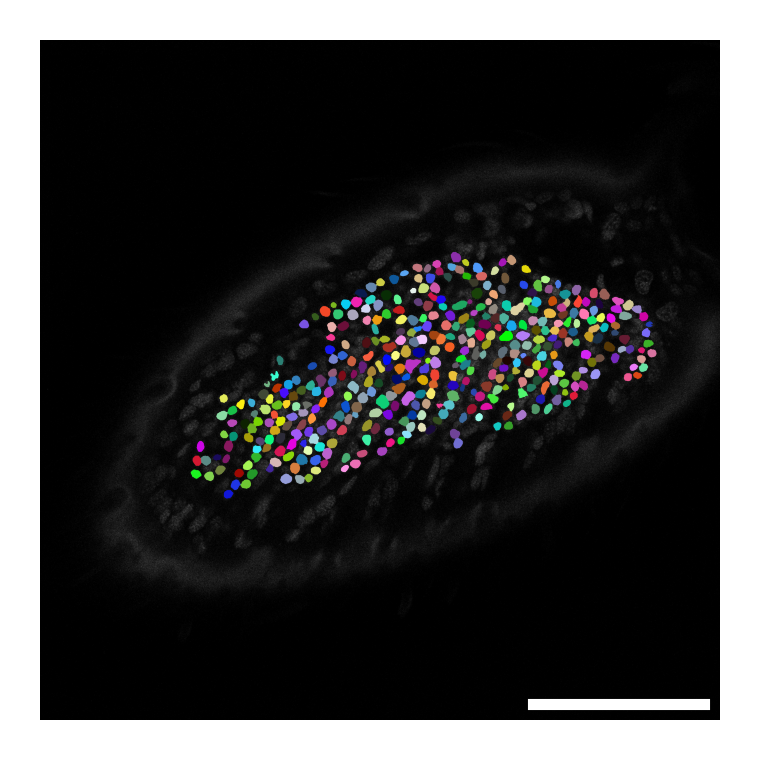

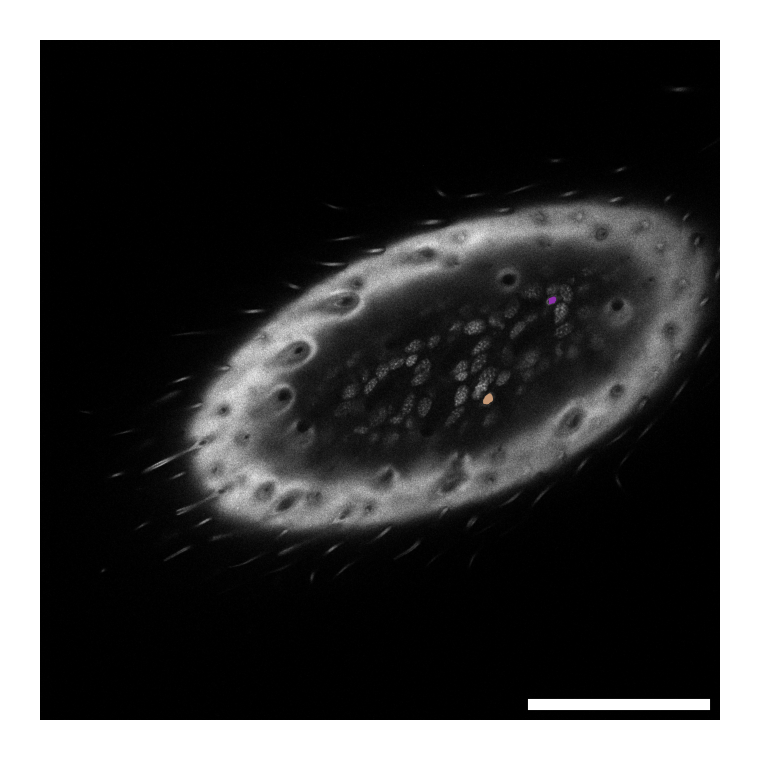

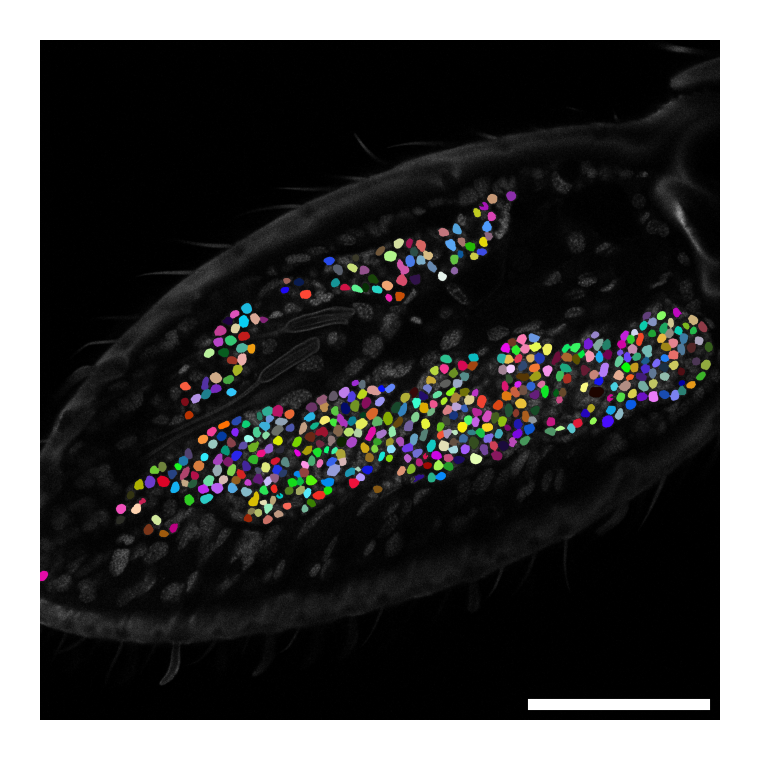

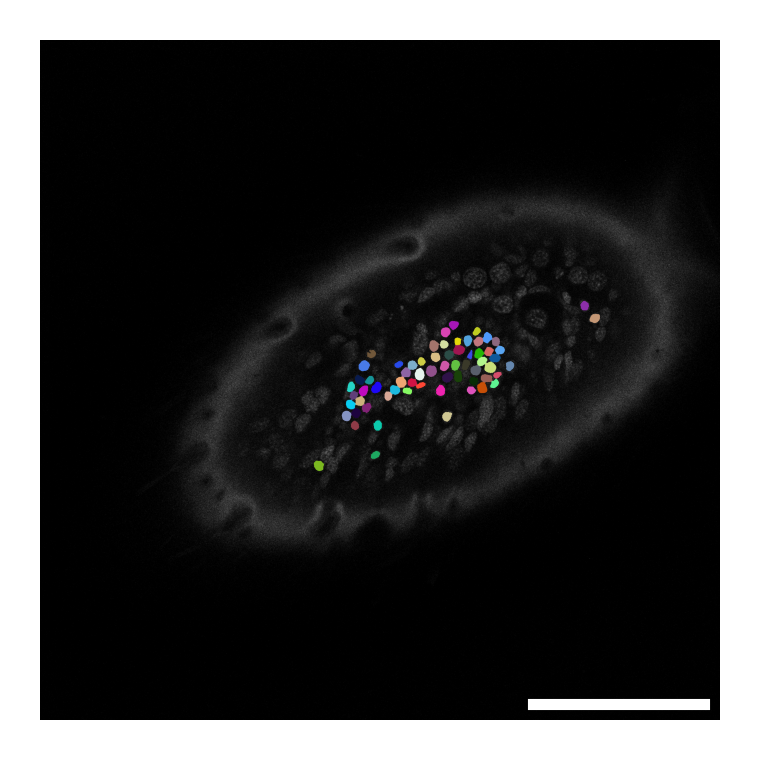

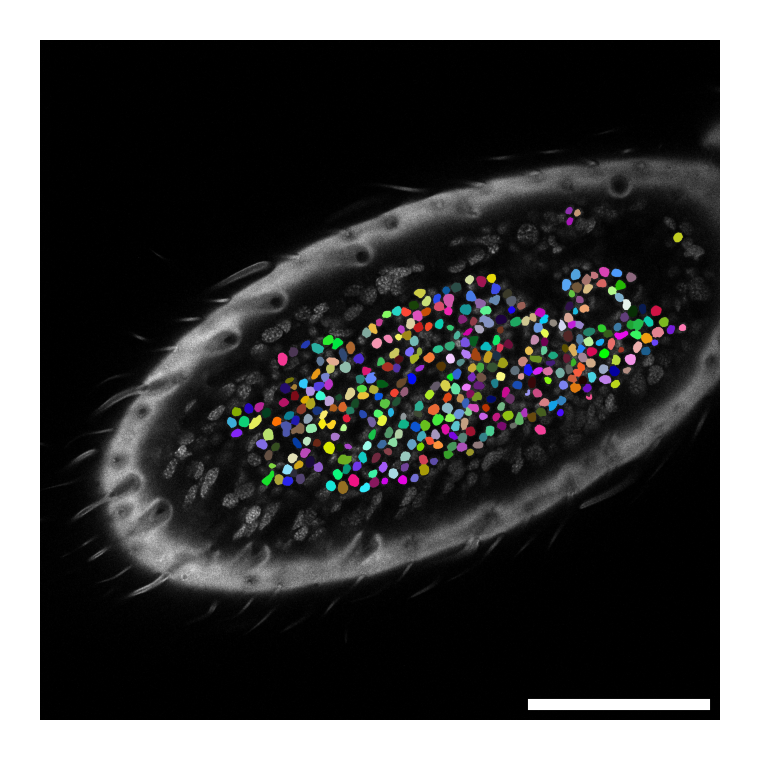

In [30]:
# Plot examples 
num_z = 5 
np.random.seed(0)
z_indices = np.random.choice(range(image_data.shape[0]), num_z)
dapi_index = metadata['name'].index([name for name in metadata['name'] if 'DAPI' in name][0])
pixel_x = metadata['scale'][2]
nucleus_diameter = 3 / pixel_x

# Plot each channel for each z slice and the masks
for i, z in enumerate(z_indices):
    img = image_data[z, dapi_index, :, :]    
    fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=400) 
    ax.imshow(set_min_max(img, 0, 150), cmap='gray')
    rois, flows, styles = model.eval(img, diameter=nucleus_diameter)
    ax.imshow(random_colormap_transparent(rois)) 
    ax.axis('off')
    # Get scale for scale bar 
    x_scale = 50 / metadata['scale'][2] # 5 um in pixels 
    ax.plot([img.shape[1] - 50 - x_scale, img.shape[1] - 50], [img.shape[0] - 50, img.shape[0] - 50], color='white', lw=2)
    plt.tight_layout() 
    plt.savefig(f"../figures/OOS-examples/{file.replace('.czi', f'_z{z}.png')}", format="png", pad_inches=0, bbox_inches=0, transparent=False)
    plt.show()